In [55]:
import numpy as np
import pandas as pd
import cv2
import os
import sys
import matplotlib.pyplot as plt
from tqdm import tqdm
from itertools import chain
import skimage
from PIL import Image
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.util import crop, pad

from skimage.morphology import label
from skimage.color import rgb2gray, gray2rgb, rgb2lab, lab2rgb
from sklearn.model_selection import train_test_split

from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.applications.vgg16 import preprocess_input
import tensorflow as tf
from tensorflow.keras.models import Model, load_model,Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Input, Dense, UpSampling2D, RepeatVector, Reshape
from tensorflow.keras.layers import Dropout, Lambda
from tensorflow.keras.layers import Conv2D, Conv2DTranspose
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import concatenate
from tensorflow.keras import backend as K

In [14]:
#!pip install -q kaggle
#!mkdir ~/.kaggle
#!touch ~/.kaggle/kaggle.json
#api_token = {"username":"Your UserName","key":"Your key"}
#import json
#with open('/root/.kaggle/kaggle.json', 'w') as file:
  # json.dump(api_token, file)
#!chmod 600 ~/.kaggle/kaggle.json
#!kaggle datasets download -d thedownhill/art-images-drawings-painting-sculpture-engraving

In [15]:
# !wget --no-check-certificate -r 'https://drive.google.com/uc?export=download&id=1CKs7s_MZMuZFBXDchcL_AgmCxgPBTJXK' -O art-images-drawings-painting-sculpture-engraving.zip

In [16]:
# !unzip art-images-drawings-painting-sculpture-engraving.zip -d /content/drive/MyDrive/Dataset/art-images-drawings-painting-sculpture-engraving

In [17]:
IMG_WIDTH = 224
IMG_HEIGHT = 224
TRAIN_PATH = '/content/drive/MyDrive/Dataset/art-images-drawings-painting-sculpture-engraving/dataset/dataset_updated/training_set/painting/'
train_ids = next(os.walk(TRAIN_PATH))[2]

In [18]:
missing_count = 0
for n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)):
  path = TRAIN_PATH + id_+ ''
  try:
    img = imread(path)  
  except:
    missing_count += 1
print("\n\nTotal missing: "+ str(missing_count))

100%|██████████| 2128/2128 [00:09<00:00, 228.20it/s]



Total missing: 86


In [19]:
X_train = np.zeros((len(train_ids)-missing_count, IMG_HEIGHT, IMG_WIDTH, 3), dtype=np.uint8)
missing_images = 0
for n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)):
  path = TRAIN_PATH + id_+ ''
  try:
    img = imread(path)
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH),
    mode='constant', preserve_range=True)
    X_train[n-missing_images] = img
  except:
    missing_images += 1
X_train = X_train.astype('float32') / 255.

100%|██████████| 2128/2128 [00:36<00:00, 58.68it/s]


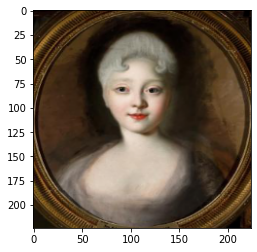

In [20]:
plt.imshow(X_train[5])

In [40]:
x_train, x_test = train_test_split(X_train,test_size=1500)

In [41]:
datagen = ImageDataGenerator( 
    shear_range=0.2,
    zoom_range=0.2,
    rotation_range=20,
    horizontal_flip=True
)

In [45]:
def image_a_b_gen(dataset=X_train):
  # iteration for every image
  for batch in datagen.flow(dataset, batch_size=542):
    # convert from rgb to grayscale
    X_batch = rgb2gray(batch)
    # convert the rgb to Lab format
    lab_batch = rgb2lab(batch)
    X_batch = lab_batch[:,:,:,1:] /128
    return X_batch

**Defining Model**

In [22]:
vggmodel = tf.keras.applications.vgg16.VGG16()

newmodel = Sequential()

num = 0

for i, layer in enumerate(vggmodel.layers):
  if i<19:
    newmodel.add(layer)

newmodel.summary()

for layer in newmodel.layers:
  layer.trainable=False

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 56, 56, 256)      

**Extracting Features**

In [43]:
vggfeatures = []
for sample in tqdm(x_train):
  sample = gray2rgb(sample)
  sample = sample.reshape((1,224,224,3))
  prediction = newmodel.predict(sample)
  prediction = prediction.reshape((7,7,512))
  vggfeatures.append(prediction)
vggfeatures = np.array(vggfeatures)

100%|██████████| 542/542 [00:24<00:00, 22.25it/s]


**Defining Network**

In [25]:
#Encoder
encoder_input = Input(shape=(7, 7, 512,))

#Decoder
decoder_output = Conv2D(256, (3,3), activation='relu', padding='same')(encoder_input)
decoder_output = Conv2D(128, (3,3),activation='relu', padding='same')(decoder_output)
decoder_output = UpSampling2D((2, 2))(decoder_output)
decoder_output = Conv2D(64, (3,3), activation='relu',padding='same')(decoder_output)
decoder_output = UpSampling2D((2, 2))(decoder_output)
decoder_output = Conv2D(32, (3,3), activation='relu',padding='same')(decoder_output)
decoder_output = UpSampling2D((2, 2))(decoder_output)
decoder_output = Conv2D(16, (3,3), activation='relu',padding='same')(decoder_output)
decoder_output = UpSampling2D((2, 2))(decoder_output)
decoder_output = Conv2D(2, (3, 3), activation='tanh',padding='same')(decoder_output)
decoder_output = UpSampling2D((2, 2))(decoder_output)

model = Model(inputs=encoder_input,outputs=decoder_output)

model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 7, 7, 512)]       0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 7, 7, 256)         1179904   
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 7, 7, 128)         295040    
_________________________________________________________________
up_sampling2d_10 (UpSampling (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 14, 14, 64)        73792     
_________________________________________________________________
up_sampling2d_11 (UpSampling (None, 28, 28, 64)        0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 28, 28, 32)        1846

**Model Training**

In [46]:
model.compile(optimizer='Adam', loss='mse')

model.fit(vggfeatures, image_a_b_gen(x_train), verbose=1, epochs=100, batch_size=128)

Epoch 1/100
5/5 [==============================] - 2s 76ms/step - loss: 0.0693
Epoch 2/100
5/5 [==============================] - 0s 39ms/step - loss: 0.0088
Epoch 3/100
5/5 [==============================] - 0s 41ms/step - loss: 0.0070
Epoch 4/100
5/5 [==============================] - 0s 39ms/step - loss: 0.0065
Epoch 5/100
5/5 [==============================] - 0s 39ms/step - loss: 0.0062
Epoch 6/100
5/5 [==============================] - 0s 40ms/step - loss: 0.0061
Epoch 7/100
5/5 [==============================] - 0s 38ms/step - loss: 0.0059
Epoch 8/100
5/5 [==============================] - 0s 37ms/step - loss: 0.0058
Epoch 9/100
5/5 [==============================] - 0s 38ms/step - loss: 0.0058
Epoch 10/100
5/5 [==============================] - 0s 38ms/step - loss: 0.0057
Epoch 11/100
5/5 [==============================] - 0s 38ms/step - loss: 0.0057
Epoch 12/100
5/5 [==============================] - 0s 40ms/step - loss: 0.0057
Epoch 13/100
5/5 [==============================]

**Inference**

/usr/local/lib/python3.7/dist-packages/skimage/color/colorconv.py:1068: UserWarning: Color data out of range: Z < 0 in 18291 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))


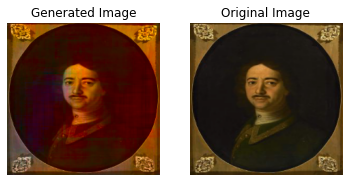

/usr/local/lib/python3.7/dist-packages/skimage/color/colorconv.py:1068: UserWarning: Color data out of range: Z < 0 in 10276 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))


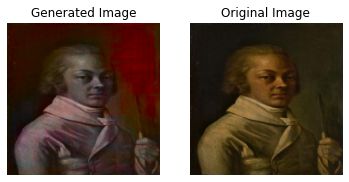

/usr/local/lib/python3.7/dist-packages/skimage/color/colorconv.py:1068: UserWarning: Color data out of range: Z < 0 in 3014 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))


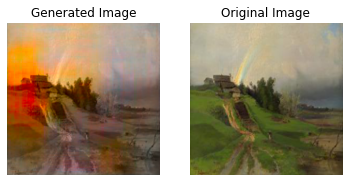

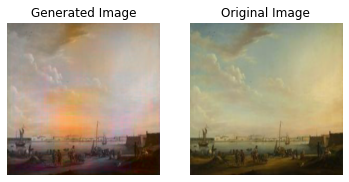

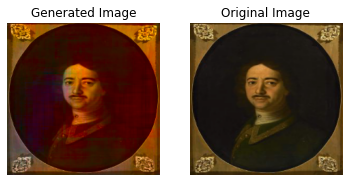

In [47]:
sample = x_test[1:6]
for image in sample:
  lab = rgb2lab(image)
  l = lab[:,:,0]
  L = gray2rgb(l)
  L = L.reshape((1,224,224,3))
  vggpred = newmodel.predict(L)
  ab = model.predict(vggpred)
  ab = ab*128
  cur = np.zeros((224, 224, 3))
  cur[:,:,0] = l
  cur[:,:,1:] = ab
  plt.subplot(1,2,1)
  plt.title("Generated Image")
  plt.imshow( lab2rgb(cur))
  plt.axis('off')
  plt.subplot(1,2,2)
  plt.title("Original Image")
  plt.imshow(image)
  plt.axis('off')
  plt.show()

**Inference on an Unseen Image**

In [50]:
!wget https://raw.githubusercontent.com/Apress/artificial-neural-networks-with-tensorflow-2/main/ch14/mountain.jpg

--2021-06-08 09:32:17--  https://raw.githubusercontent.com/Apress/artificial-neural-networks-with-tensorflow-2/main/ch14/mountain.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 180557 (176K) [image/jpeg]
Saving to: ‘mountain.jpg’

mountain.jpg        100%[===================>] 176.33K  --.-KB/s    in 0.02s   

2021-06-08 09:32:17 (10.0 MB/s) - ‘mountain.jpg’ saved [180557/180557]



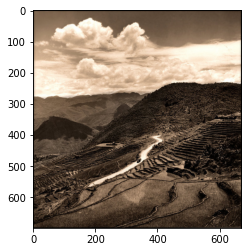

In [51]:
img = imread("mountain.jpg")
plt.imshow(img)

/usr/local/lib/python3.7/dist-packages/skimage/color/colorconv.py:1068: UserWarning: Color data out of range: Z < 0 in 11674 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))


(-0.5, 223.5, 223.5, -0.5)

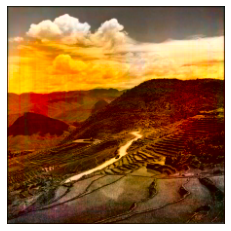

In [56]:
test = img_to_array(load_img("mountain.jpg"))
test = resize(test, (224,224), anti_aliasing=True)
test *= 1.0/255
lab = rgb2lab(test)
l = lab[:,:,0]
L = gray2rgb(l)
L = L.reshape((1,224,224,3))
vggpred = newmodel.predict(L)
ab = model.predict(vggpred)
ab = ab*128
cur = np.zeros((224, 224, 3))
cur[:,:,0] = l
cur[:,:,1:] = ab
plt.imshow( lab2rgb(cur))
plt.axis('off')